## Track upwelled water using a step profile

I added two tracers, besides the original advetive tracer with linear profile, to track water upwelled through the canyon. One has a concentration of 1 below the shelf break depth and 0 above; the otherone has 0 below shelf break depth and 1 above, to track shelf water. 

These preliminary runs are under CNTDIFF_STEP. Run38 is the base case with canyon and run42 is the base case without a canyon. 

In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import canyon_tools.metrics_tools as mtt 

In [3]:
sns.set_style('dark')

In [4]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [152.5],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [5]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/stateGlob.nc' 
ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/ptracersGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/gridGlob.nc'
state_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/stateGlob.nc' 
ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/ptracersGlob.nc' 
# Still waiting for this run to finish on graham


In [6]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    drF = nbl.variables['drF'][:]
    dxF = nbl.variables['dxF'][:,:]
    dyF = nbl.variables['dyF'][:,:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)
    
with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]
    hFacSNoC = nbl.variables['HFacS'][:]

hfacNoC = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfacNoC)

hfacsNoC = np.ma.masked_values(hFacSNoC, 0)
maskSNoC = np.ma.getmask(hfacsNoC)

    
with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

### Comparison of all 4 tracers at days 1, 4, 8

#### Canyon axis

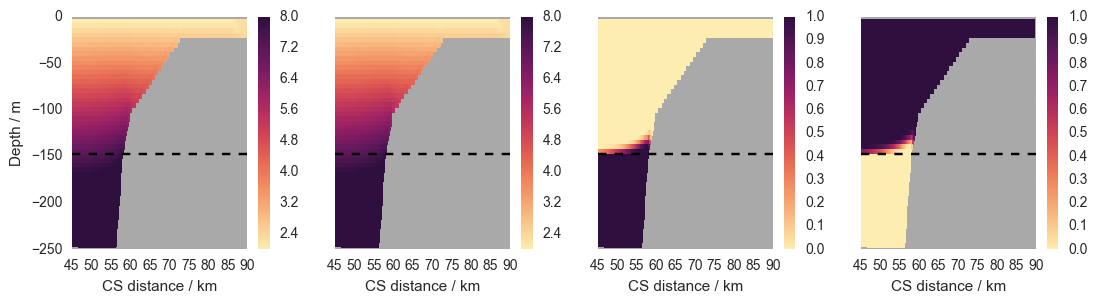

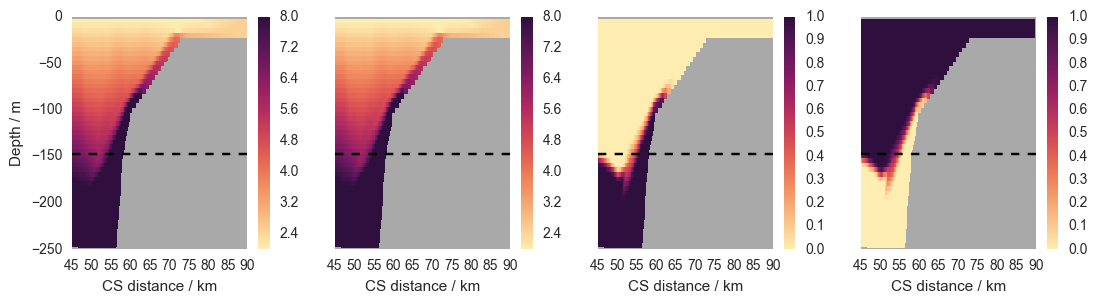

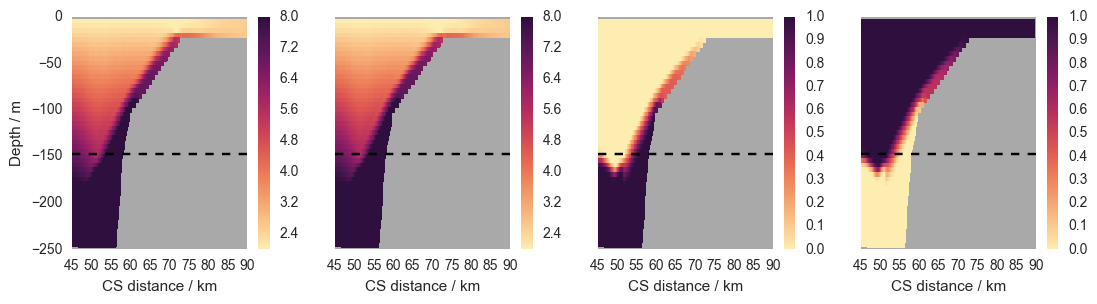

In [7]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 180 # canyon axis
yslice = slice(180,360)


for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

#### Downstream shelf

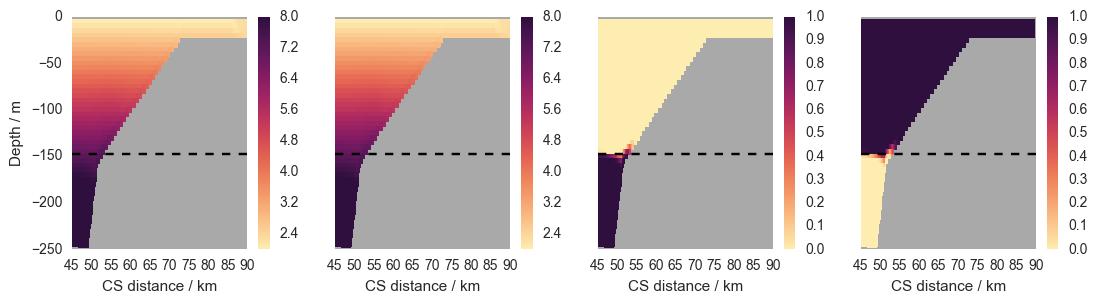

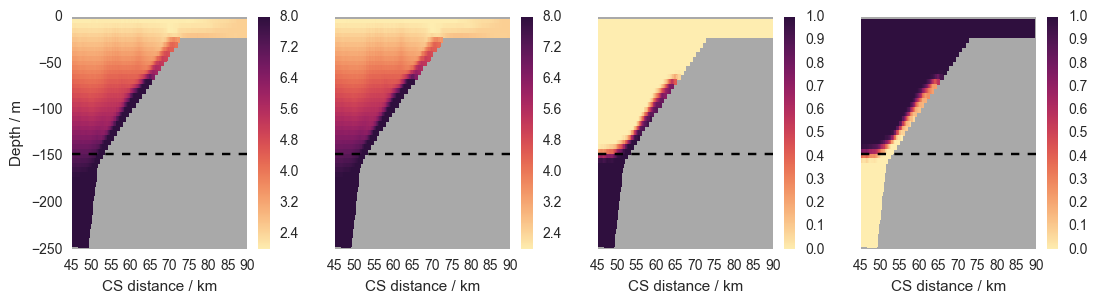

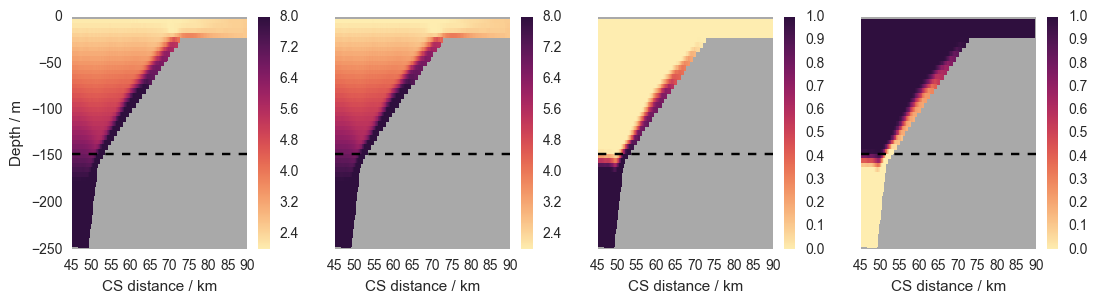

In [8]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 240 # canyon axis
yslice = slice(180,360)

for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

### Mean bottom concentration during advective phase

In [9]:
yslice_pl = slice(225,360)
xslice_pl = slice(120,500)

with Dataset(ptracers_file, 'r') as ptr:
    ConcAreaTr1, ConcTr1, AreaTr1 = BottomConc(np.mean(ptr.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr2, ConcTr2, AreaTr2 = BottomConc(np.mean(ptr.variables['Tr2'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr3, ConcTr3, AreaTr3 = BottomConc(np.mean(ptr.variables['Tr3'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr4, ConcTr4, AreaTr4 = BottomConc(np.mean(ptr.variables['Tr4'][8:18,:,:,:], axis=0),hFacC,rA,Depth)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
with Dataset(ptracers_file, 'r') as ptr:
    
    with Dataset(ptracers_fileNoC, 'r') as ptr_NoC:
        
        ConcAreaTr1Anom, ConcTr1Anom, AreaTr1Anom = BottomConc(np.mean(ptr.variables['Tr1'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr1'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr2Anom, ConcTr2Anom, AreaTr2Anom = BottomConc(np.mean(ptr.variables['Tr2'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr2'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr3Anom, ConcTr3Anom, AreaTr3Anom = BottomConc(np.mean(ptr.variables['Tr3'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr3'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
        ConcAreaTr4Anom, ConcTr4Anom, AreaTr4Anom = BottomConc(np.mean(ptr.variables['Tr4'][8:18,:,:,:]-
                                                                       ptr_NoC.variables['Tr4'][8:18,:,:,:], axis=0),
                                                               hFacCNoC,rA,Depth)
       

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


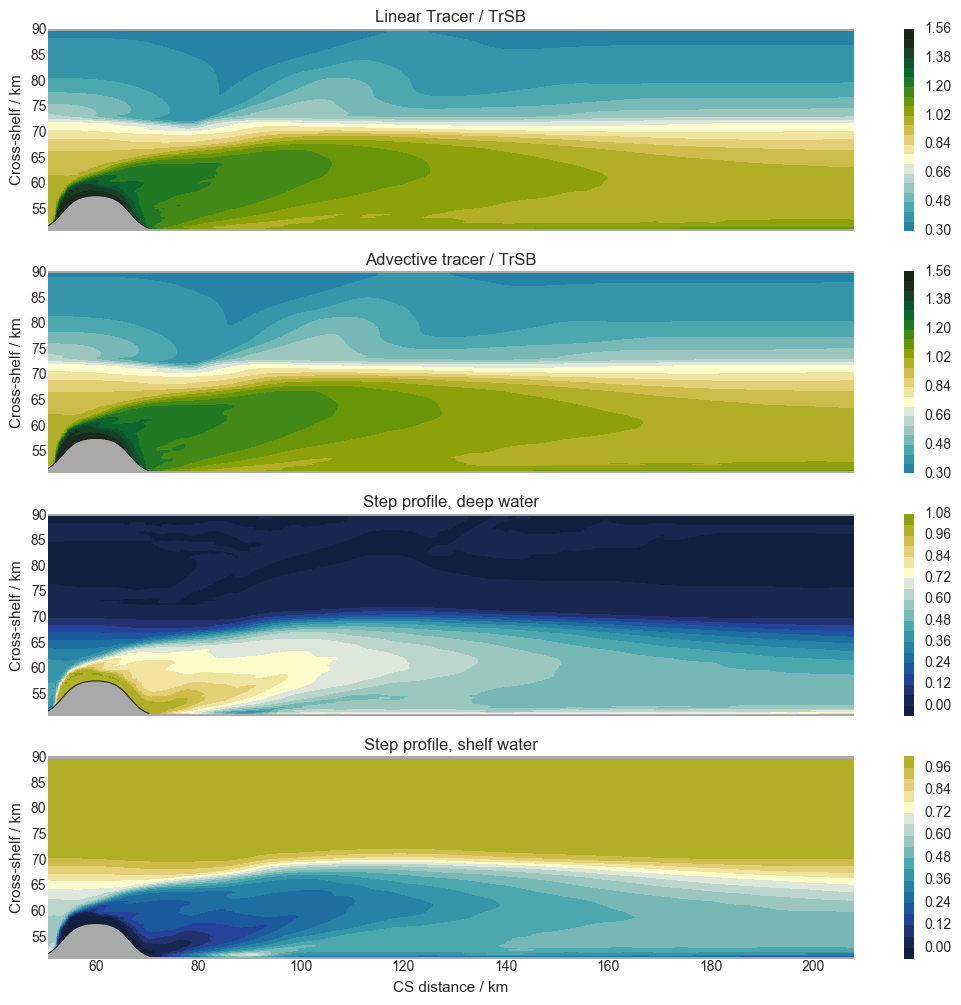

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(13,12), sharey=True, sharex = True)

mesh1 = PlotPool(ax1,ConcTr1/7.21,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh2 = PlotPool(ax2,ConcTr2/7.21,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh3 = PlotPool(ax3,ConcTr3,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)
mesh4 = PlotPool(ax4,ConcTr4,xslice_pl,yslice_pl, cmo.cm.delta, cmin=0, cmax=1.5)

plt.colorbar(mesh1, ax=ax1)
plt.colorbar(mesh2, ax=ax2)
plt.colorbar(mesh3, ax=ax3)
plt.colorbar(mesh4, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_bgcolor("darkgrey")
    ax.set_ylabel('Cross-shelf / km')

ax4.set_xlabel('CS distance / km')
ax1.set_title('Linear Tracer / TrSB')
ax2.set_title('Advective tracer / TrSB')
ax3.set_title('Step profile, deep water')
ax4.set_title('Step profile, shelf water')

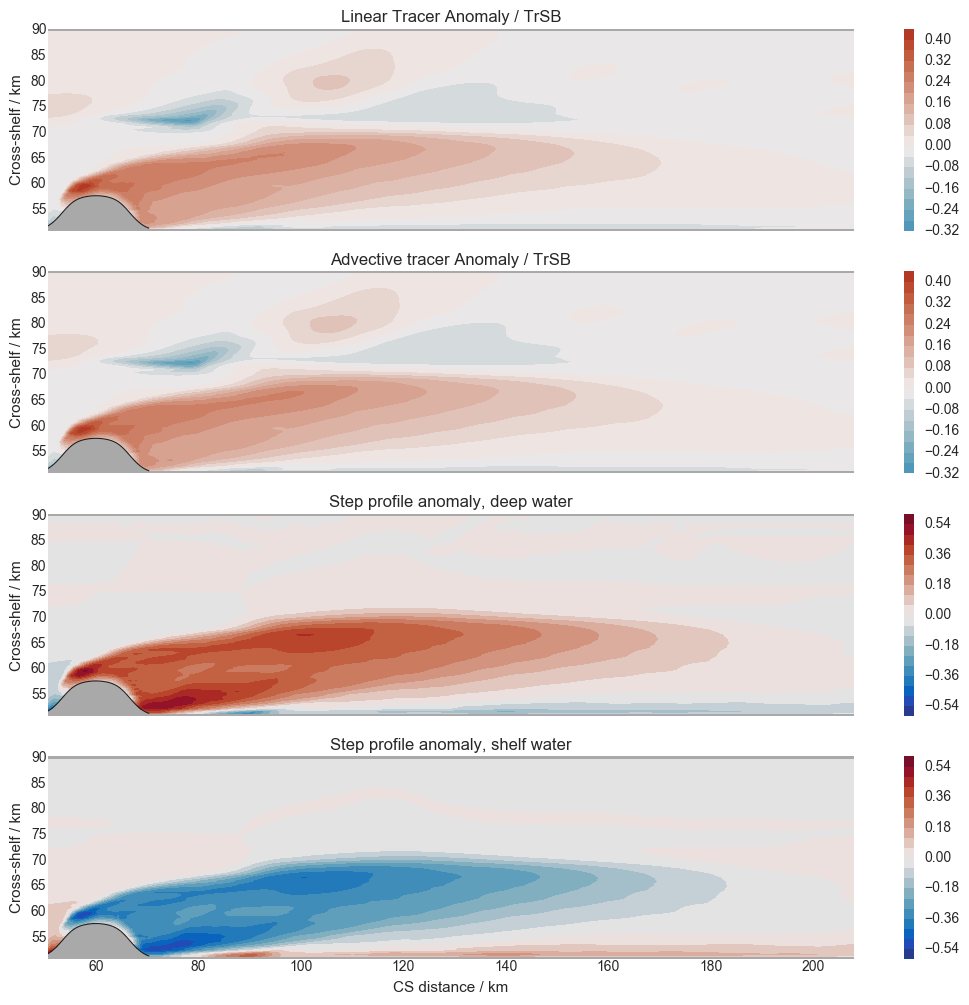

In [12]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(13,12), sharey=True, sharex = True)

mesh1 = PlotPool(ax1,ConcTr1Anom/7.21,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh2 = PlotPool(ax2,ConcTr2Anom/7.21,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh3 = PlotPool(ax3,ConcTr3Anom,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)
mesh4 = PlotPool(ax4,ConcTr4Anom,xslice_pl,yslice_pl, cmo.cm.balance, cmin=-0.7, cmax=0.7)

plt.colorbar(mesh1, ax=ax1)
plt.colorbar(mesh2, ax=ax2)
plt.colorbar(mesh3, ax=ax3)
plt.colorbar(mesh4, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_bgcolor("darkgrey")
    ax.set_ylabel('Cross-shelf / km')

ax4.set_xlabel('CS distance / km')
ax1.set_title('Linear Tracer Anomaly / TrSB')
ax2.set_title('Advective tracer Anomaly / TrSB')
ax3.set_title('Step profile anomaly, deep water')
ax4.set_title('Step profile anomaly, shelf water')

### Tracking water 

In [13]:
def calc_HCW(Tr,MaskC,rA,hFacC,drF,trlim=7.21,nzlim=29,xi=180,yi=50):
    ''' Calculate HCW for linear profiles'''
    
    maskExp = mtt.maskExpand(MaskC,Tr)
    TrMask = np.ma.array(Tr,mask=maskExp)   

    print('tracer limit concentration is: ',trlim)
      
    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:,:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask
    
    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
    
    ShelfVolume = hFacC[:,:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=2)
    
    TrConc_HCW = np.ma.masked_array(Tr,mask = HighConc_Mask) 

    MassTrHighConc =np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol*TrConc_HCW,axis = 1),axis=1),axis=1)

    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask,axis = 1),axis=1),axis=1)
    
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across, MassTrHighConc, Total_Tracer)
 
def calc_HCW_step(Tr,MaskC,rA,hFacC,drF):
    ''' Calculate HCW for step profile'''
    
    maskExp = mtt.maskExpand(MaskC,Tr)
    TrMask = np.ma.array(Tr,mask=maskExp)   
    trlim = 0.5
    
    #Get fraction of volume of upwelled water
    rA_exp = np.expand_dims(rA[:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:,:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:,:,:].shape)
    
    ShelfVolume = hFacC[:,:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(maskExp.shape)
    
    HighConc_CellVol = ShelfVolume_exp*TrMask
    VolWaterHighConc = np.zeros(np.shape(Tr)[0])+np.ma.sum(np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1),axis=1)
    VolWaterHighConc_along = np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    VolWaterHighConc_across = np.ma.sum(np.ma.sum(HighConc_CellVol*TrMask,axis = 1),axis=2)
    
    
    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask,axis = 1),axis=1),axis=1)
    
    return (VolWaterHighConc,VolWaterHighConc_along,VolWaterHighConc_across, Total_Tracer)
 
 

In [75]:
with Dataset(ptracers_file, 'r') as ptr:
    print(ptr.variables['Tr1'][0,0:35,50,50])
    HCW1, HCW_AS1, HCW_CS1,  HCW_mass1, TrMass1 = calc_HCW(ptr.variables['Tr1'][:,0:30,230:,:],maskCNoC[:30,230:,:],
                                                           rA[230:,:],hFacCNoC[:30,230:,:],drF[:30],trlim=7.21757317,xi=180,yi=3)
    HCW2, HCW_AS2, HCW_CS2, HCW_mass2,  TrMass2 = calc_HCW(ptr.variables['Tr2'][:,0:30,230:,:],maskCNoC[:30,230:,:],
                                                           rA[230:,:],hFacCNoC[:30,230:,:],drF[:30],trlim=7.21757317,xi=180,yi=3)
    HCW3, HCW_AS3,HCW_CS3,  TrMass3 = calc_HCW_step(ptr.variables['Tr3'][:,0:30,230:,:],maskCNoC[:30,230:,:],
                                                    rA[230:,:],hFacCNoC[:30,230:,:],drF[:30])
    HCW4, HCW_AS4,HCW_CS4,  TrMass4 = calc_HCW_step(ptr.variables['Tr4'][:,0:30,230:,:],maskCNoC[:30,230:,:],
                                                    rA[230:,:],hFacCNoC[:30,230:,:],drF[:30])
  

[ 2.          2.17991638  2.35983253  2.53974891  2.71966529  2.89958167
  3.07949781  3.2594142   3.43933058  3.61924696  3.7991631   3.97907948
  4.15899563  4.33891201  4.51882839  4.69874477  4.87866116  5.05857754
  5.23849392  5.41840982  5.59832621  5.77824259  5.95815897  6.13807535
  6.31799173  6.49790812  6.6778245   6.8577404   7.03765678  7.21757317
  7.39748955  7.57740593  7.75732231  7.93723869  8.11715508]
tracer limit concentration is:  7.21757317
tracer limit concentration is:  7.21757317


In [76]:
with Dataset(ptracers_fileNoC, 'r') as ptr:
    HCW1NoC, HCW_AS1NoC, HCW_CS1NoC, HCW_mass1NoC, TrMass1NoC = calc_HCW(ptr.variables['Tr1'][:,0:30,230:,:],
                                                                         maskCNoC[:30,230:,:],rA[230:,:],
                                                                         hFacCNoC[:30,230:,:],drF[:30],trlim=7.21757317,
                                                                         xi=180,yi=0)
    HCW2NoC, HCW_AS2NoC, HCW_CS2NoC, HCW_mass2NoC, TrMass2NoC = calc_HCW(ptr.variables['Tr2'][:,0:30,230:,:],
                                                                         maskCNoC[:30,230:,:],rA[230:,:],
                                                                         hFacCNoC[:30,230:,:],drF[:30],trlim=7.21757317,
                                                                         xi=180,yi=0)
    HCW3NoC, HCW_AS3NoC, HCW_CS3NoC, TrMass3NoC = calc_HCW_step(ptr.variables['Tr3'][:,0:30,230:,:],
                                                                              maskCNoC[:30,230:,:],rA[230:,:],
                                                                              hFacCNoC[:30,230:,:],drF[:30],
                                                                              )
    HCW4NoC, HCW_AS4NoC, HCW_CS4NoC, TrMass4NoC = calc_HCW_step(ptr.variables['Tr4'][:,0:30,230:,:],
                                                                              maskCNoC[:30,230:,:],rA[230:,:],
                                                                              hFacCNoC[:30,230:,:],drF[:30],
                                                                              )


tracer limit concentration is:  7.21757317
tracer limit concentration is:  7.21757317


-- --
-- --
0.0 0.0


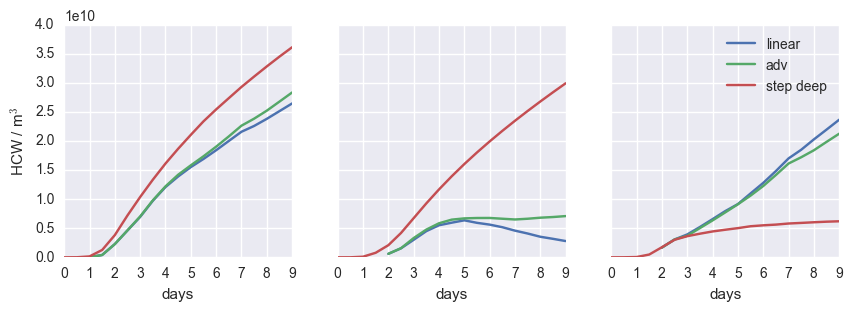

In [77]:
sns.set_style('darkgrid')

HCWs_canyon = [HCW1, HCW2, HCW3]
HCWs_NoC = [HCW1NoC, HCW2NoC, HCW3NoC]
labels = ['linear','adv','step deep', 'step shelf']

fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)

for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
    ax[0].plot(np.arange(19)/2, HCW, label=lab)
    ax[1].plot(np.arange(19)/2, HCWNoC, label=lab)
    ax[2].plot(np.arange(19)/2, HCW-HCWNoC, label=lab)
    print(HCWNoC[0], HCW[0])

ax[2].legend(loc=0)
ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[2].set_xlabel('days')
#ax[0].set_ylim(0,4E10)

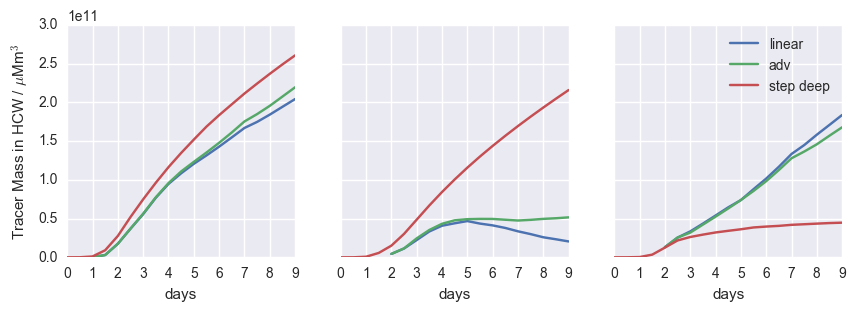

In [78]:
sns.set_style('darkgrid')

HCWMasses_canyon = [HCW_mass1, HCW_mass2, TrMass3*7.21]
HCWMasses_NoC = [HCW_mass1NoC, HCW_mass2NoC, TrMass3NoC*7.21]
labels = ['linear','adv','step deep', 'step shelf']

fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)

for HCW, HCWNoC, lab in zip(HCWMasses_canyon, HCWMasses_NoC, labels):
    ax[0].plot(np.arange(19)/2, HCW, label=lab)
    ax[1].plot(np.arange(19)/2, HCWNoC, label=lab)
    ax[2].plot(np.arange(19)/2, HCW-HCWNoC, label=lab)

ax[2].legend(loc=0)
ax[0].set_ylabel('Tracer Mass in HCW / $\mu$Mm$^3$')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[2].set_xlabel('days')
#ax[0].set_ylim(0,4E10)

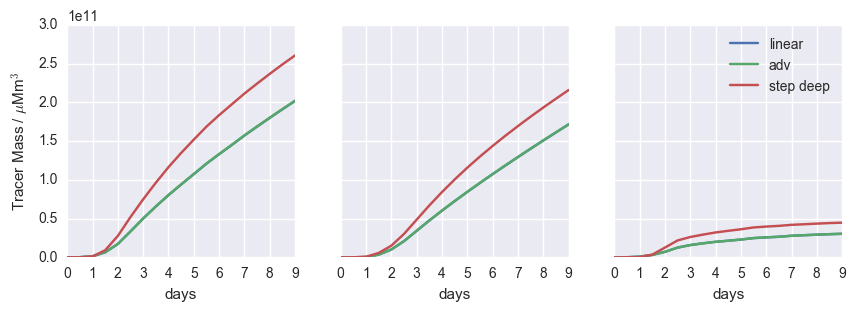

In [79]:
sns.set_style('darkgrid')

HCWMasses_canyon = [TrMass1, TrMass2, TrMass3*7.21]
HCWMasses_NoC = [TrMass1NoC, TrMass2NoC, TrMass3NoC*7.21]
labels = ['linear','adv','step deep', 'step shelf']

fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)

for HCW, HCWNoC, lab in zip(HCWMasses_canyon, HCWMasses_NoC, labels):
    ax[0].plot(np.arange(19)/2, HCW-HCW[0], label=lab)
    ax[1].plot(np.arange(19)/2, HCWNoC-HCWNoC[0], label=lab)
    ax[2].plot(np.arange(19)/2, HCW-HCWNoC, label=lab)

ax[2].legend(loc=0)
ax[0].set_ylabel('Tracer Mass / $\mu$Mm$^3$')
ax[0].set_xlabel('days')
ax[1].set_xlabel('days')
ax[2].set_xlabel('days')
#ax[0].set_ylim(0,4E10)

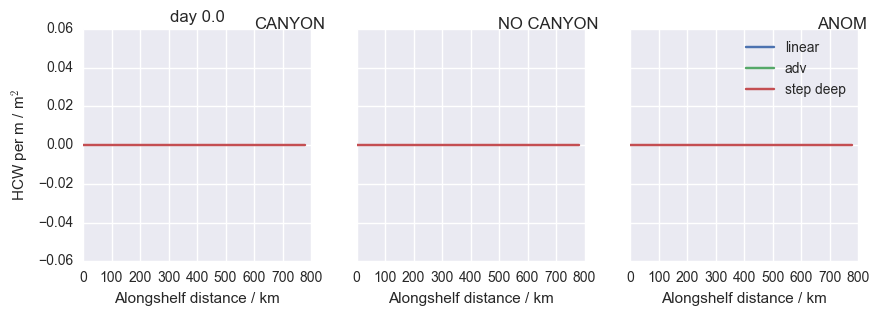

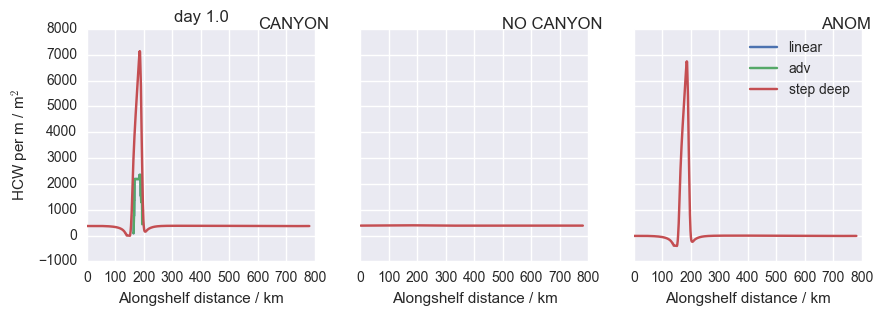

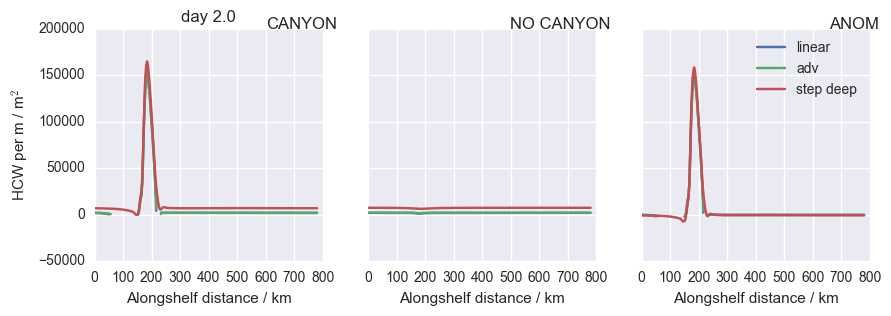

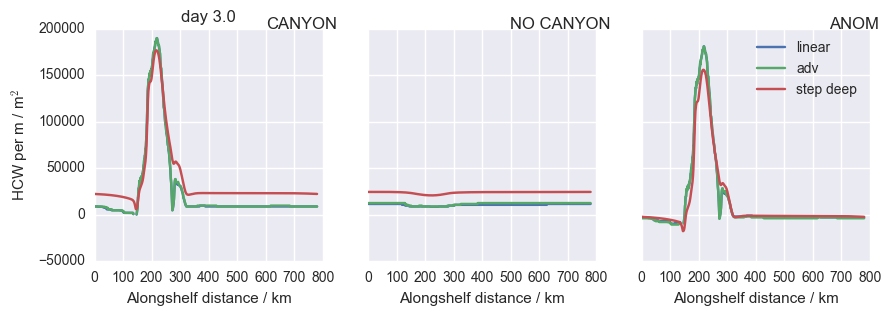

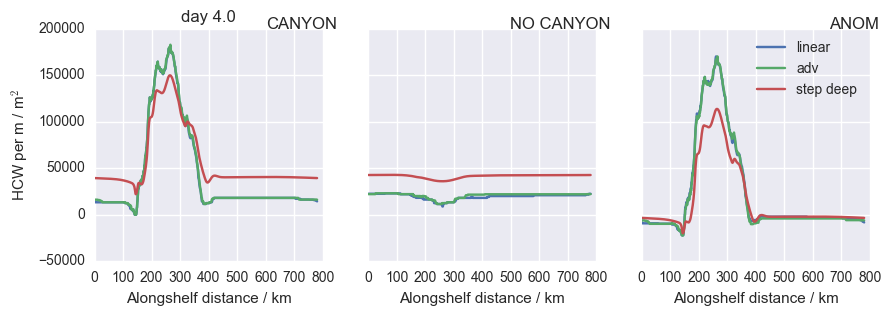

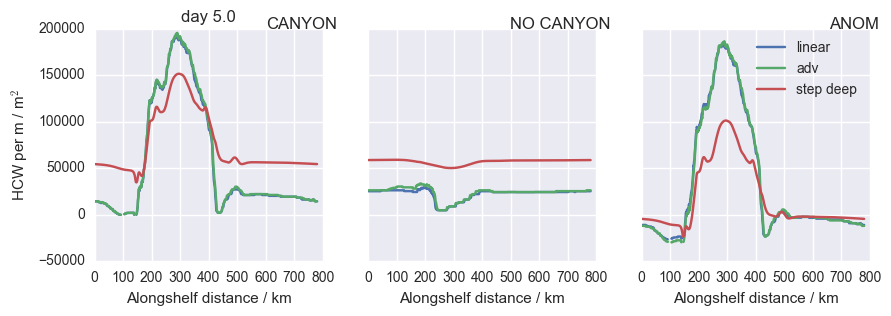

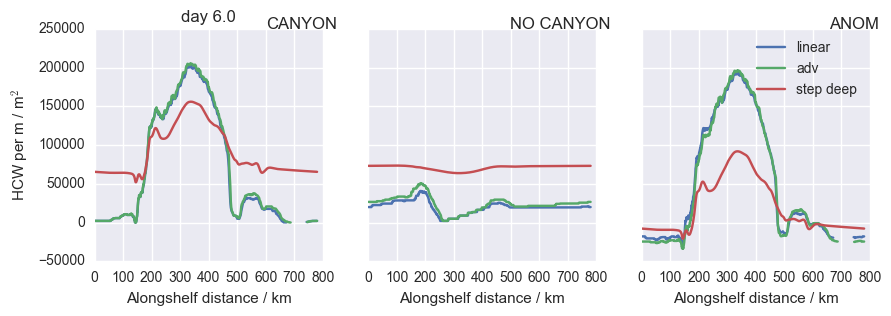

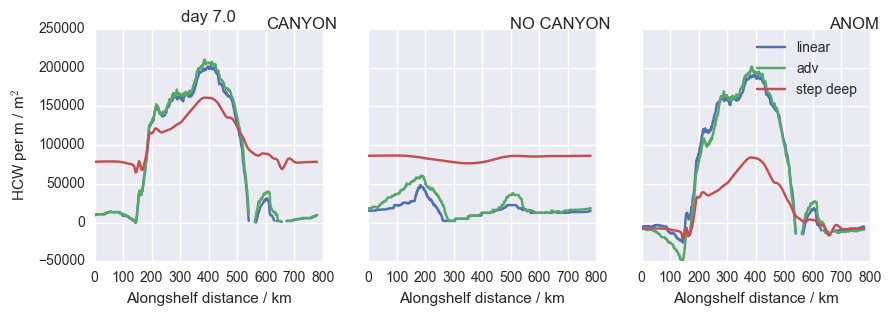

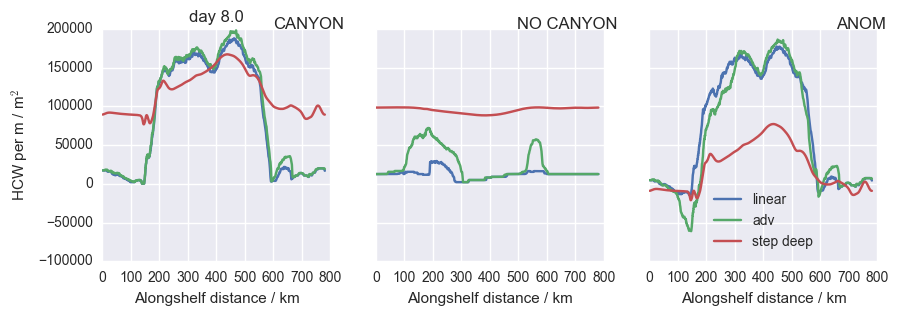

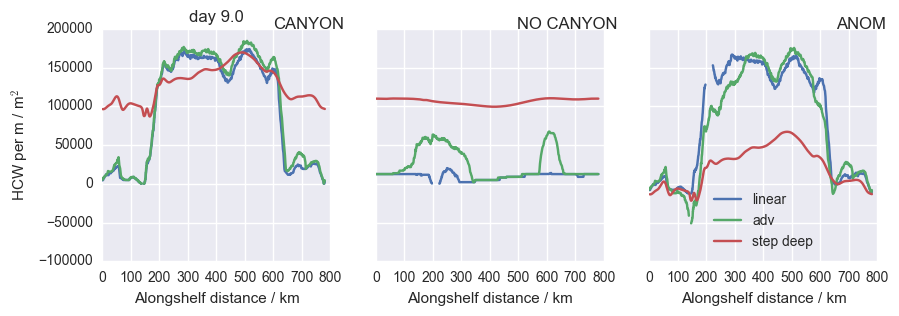

In [80]:
HCWs_canyon = [HCW_AS1, HCW_AS2, HCW_AS3]
HCWs_NoC = [HCW_AS1NoC, HCW_AS2NoC, HCW_AS3NoC]
labels = ['linear','adv','step deep', 'step shelf']

times = [0,2,4,6,8,10,12,14,16,18]


for tt in times:
    fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
        ax[0].plot(X/360, HCW[tt,:]/dxF[0,:], label=lab)
        ax[1].plot(X/360, HCWNoC[tt,:]/dxF[0,:], label=lab)
        ax[2].plot(X/360, (HCW[tt,:]-HCWNoC[tt,:])/dxF[0,:], label=lab)
    
    ax[0].text(0.75,1,'CANYON',transform=ax[0].transAxes)
    ax[1].text(0.62,1,'NO CANYON',transform=ax[1].transAxes)
    ax[2].text(0.82,1,'ANOM',transform=ax[2].transAxes)
    ax[0].set_title('day %1.1f' %(tt/2))
    ax[2].legend(loc=0)
    ax[0].set_ylabel(r'HCW per m / m$^2$')
    ax[0].set_xlabel(r'Alongshelf distance / km')
    ax[1].set_xlabel(r'Alongshelf distance / km')
    ax[2].set_xlabel(r'Alongshelf distance / km')
    



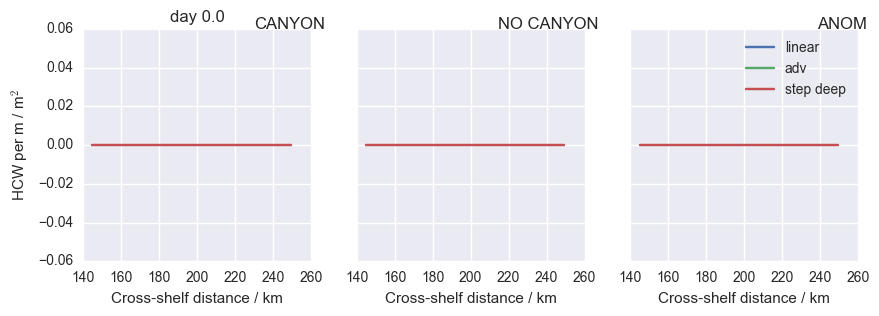

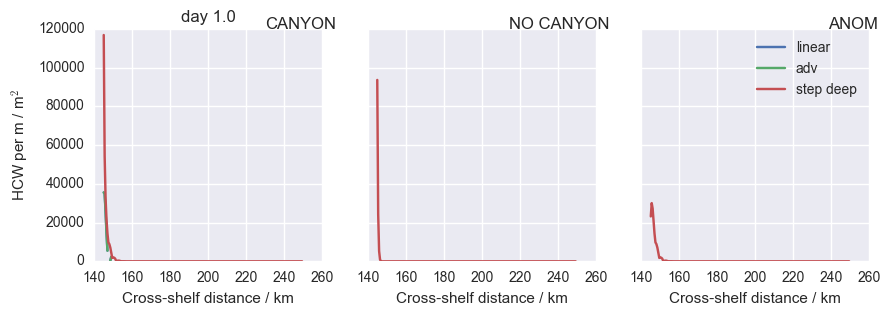

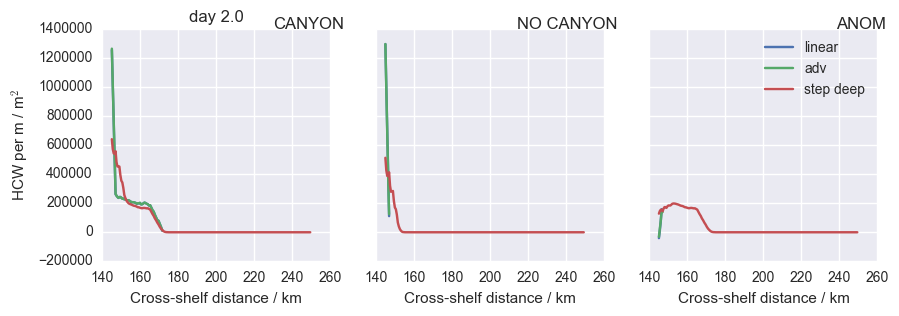

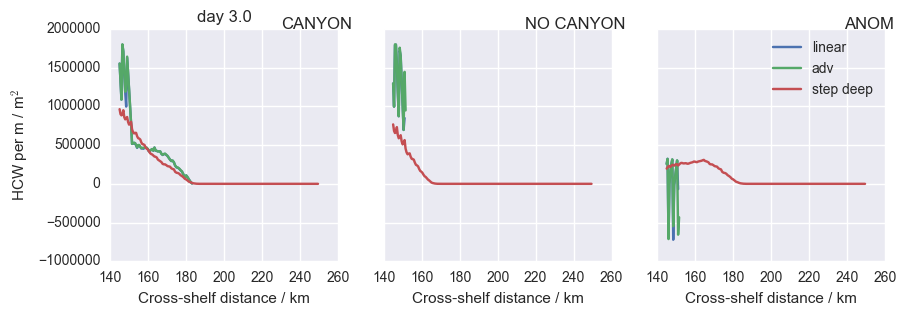

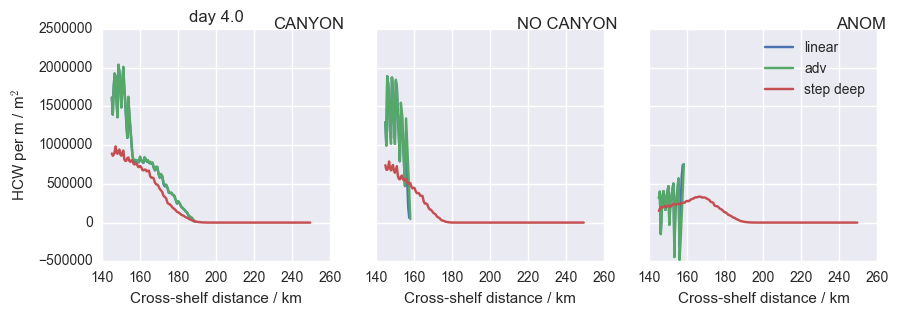

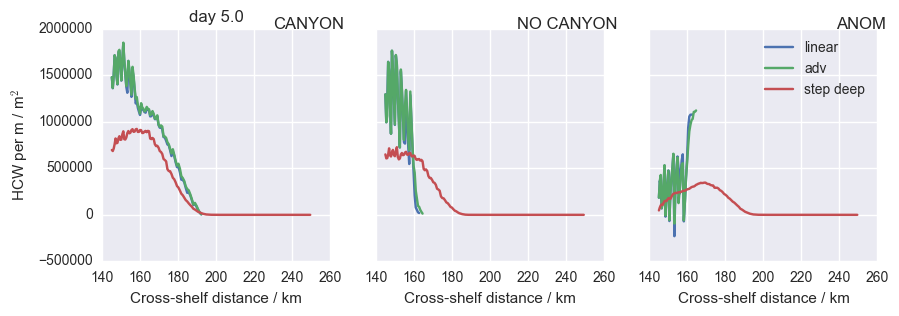

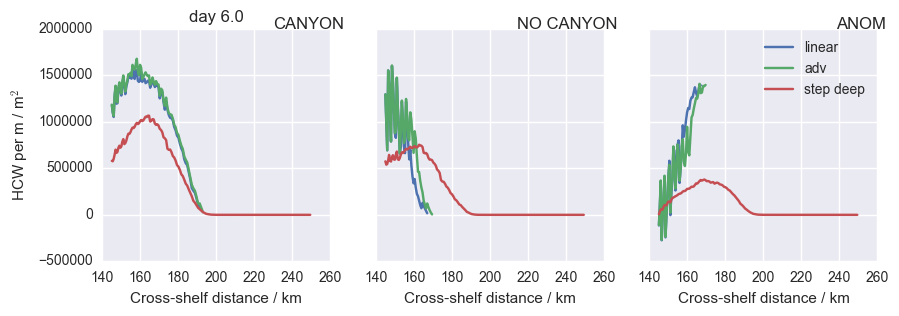

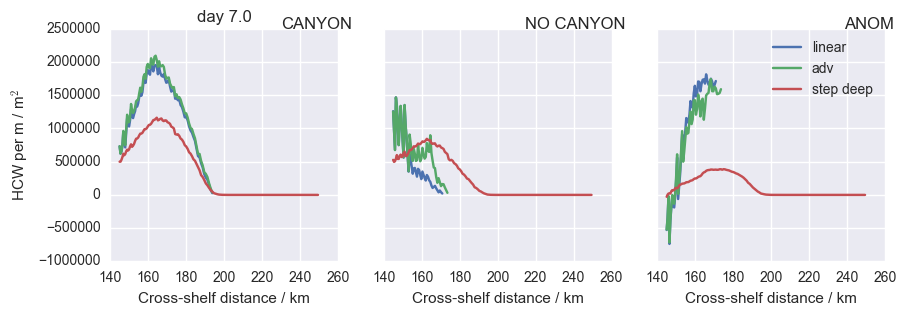

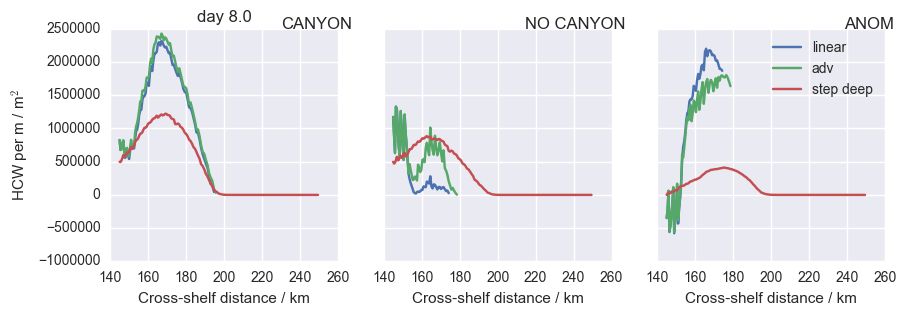

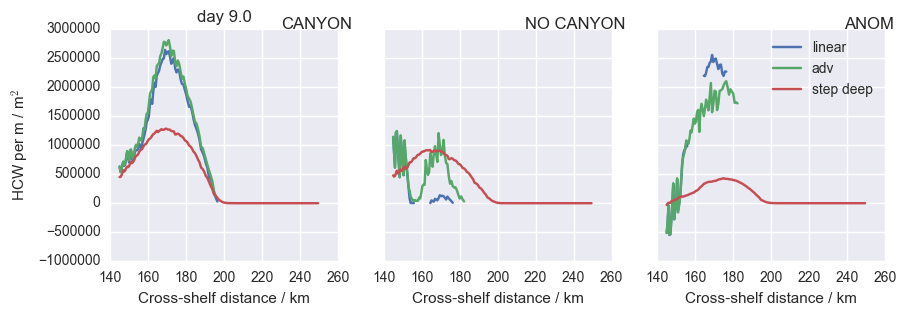

In [82]:
HCWs_canyon = [HCW_CS1, HCW_CS2, HCW_CS3]
HCWs_NoC = [HCW_CS1NoC, HCW_CS2NoC, HCW_CS3NoC]
labels = ['linear','adv','step deep', 'step shelf']

times = [0,2,4,6,8,10,12,14,16,18]


for tt in times:
    fig, ax = plt.subplots(1,3,figsize=(10,3), sharey=True)
    for HCW, HCWNoC, lab in zip(HCWs_canyon, HCWs_NoC, labels):
        ax[0].plot(Y[230:]/360, HCW[tt,:]/dyF[230:,0], label=lab)
        ax[1].plot(Y[230:]/360, HCWNoC[tt,:]/dyF[230:,0], label=lab)
        ax[2].plot(Y[230:]/360, (HCW[tt,:]-HCWNoC[tt,:])/dyF[230:,0], label=lab)
    
    ax[0].text(0.75,1,'CANYON',transform=ax[0].transAxes)
    ax[1].text(0.62,1,'NO CANYON',transform=ax[1].transAxes)
    ax[2].text(0.82,1,'ANOM',transform=ax[2].transAxes)
    ax[0].set_title('day %1.1f' %(tt/2))
    ax[2].legend(loc=0)
    ax[0].set_ylabel(r'HCW per m / m$^2$')
    ax[0].set_xlabel(r'Cross-shelf distance / km')
    ax[1].set_xlabel(r'Cross-shelf distance / km')
    ax[2].set_xlabel(r'Cross-shelf distance / km')
    

### Cross-shelf transport, no canyon case

/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


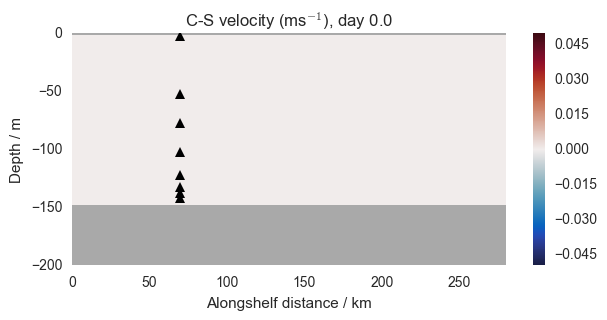

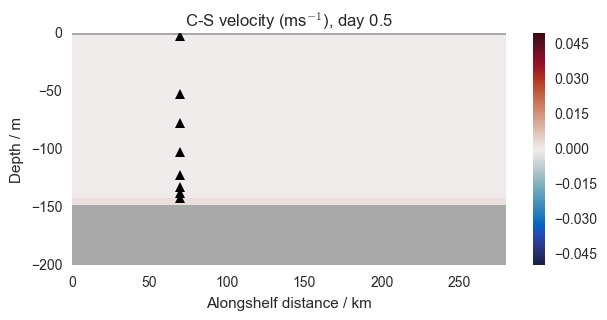

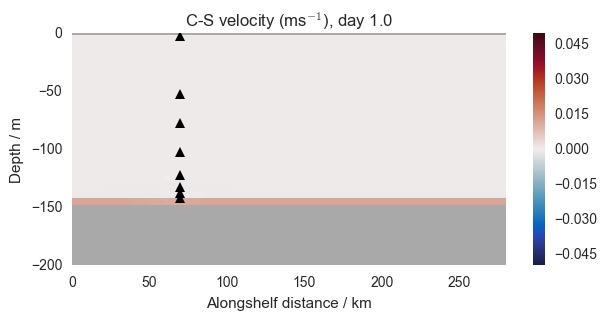

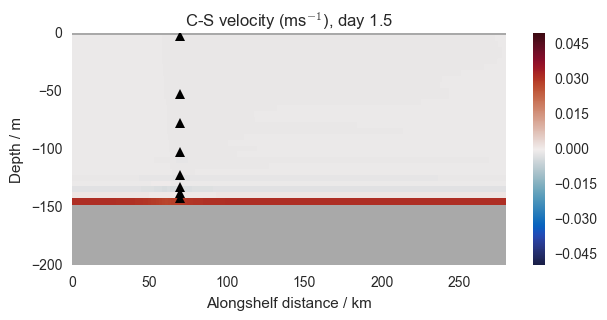

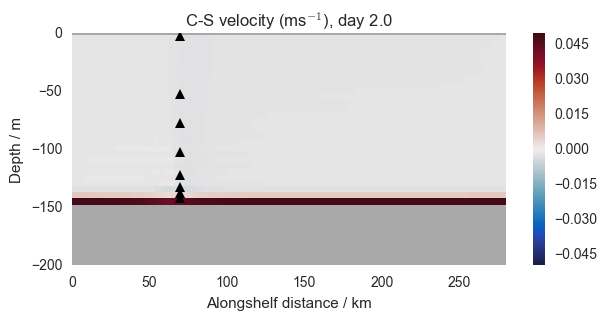

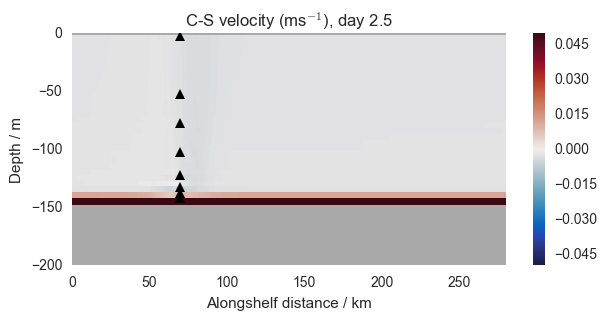

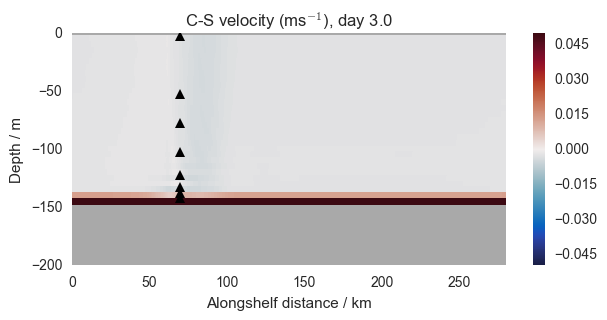

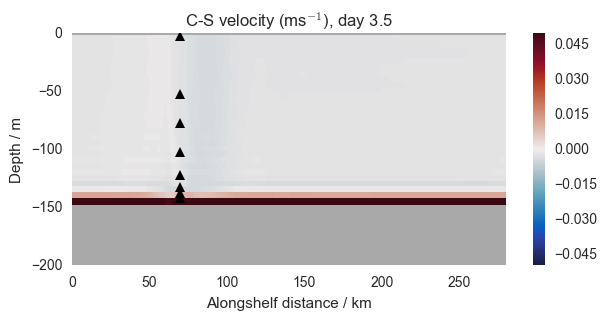

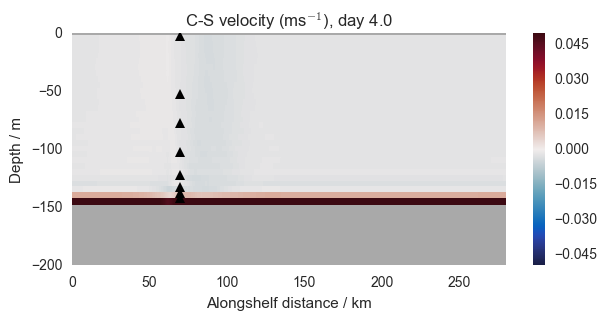

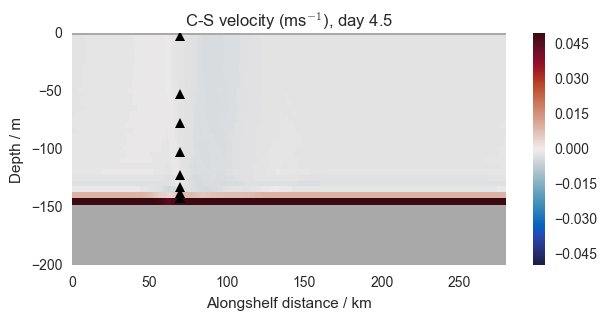

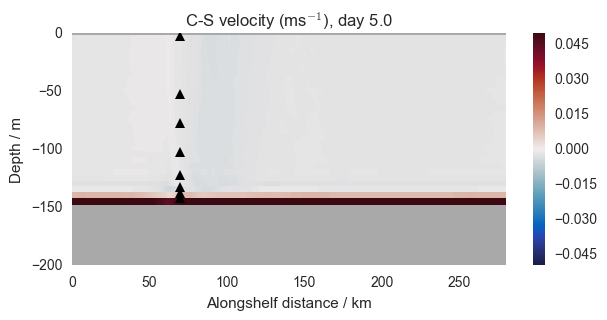

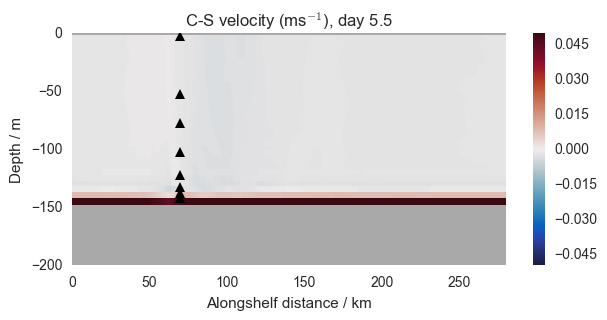

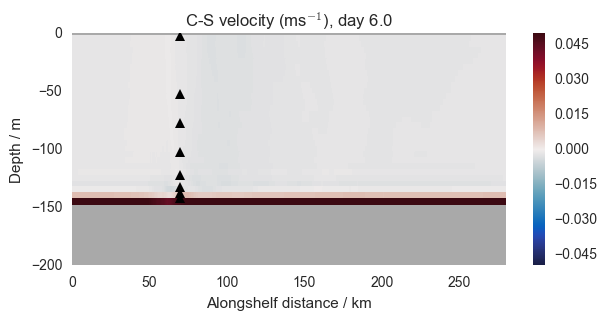

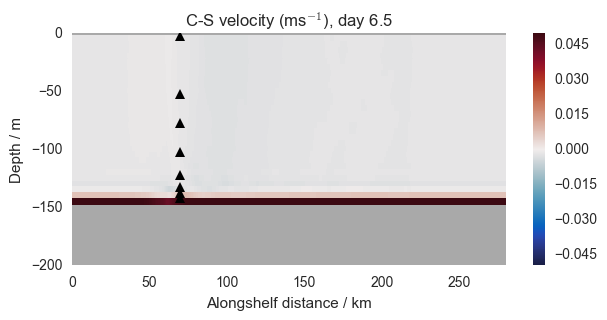

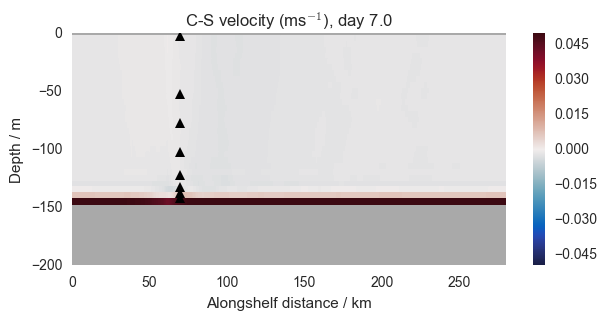

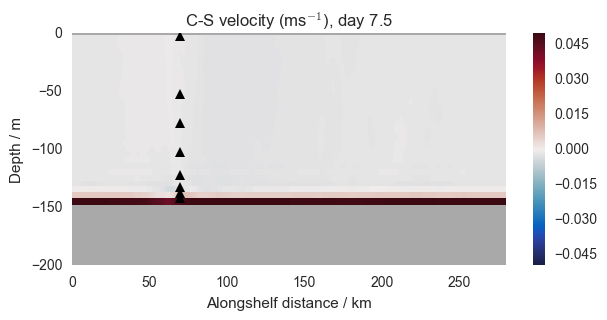

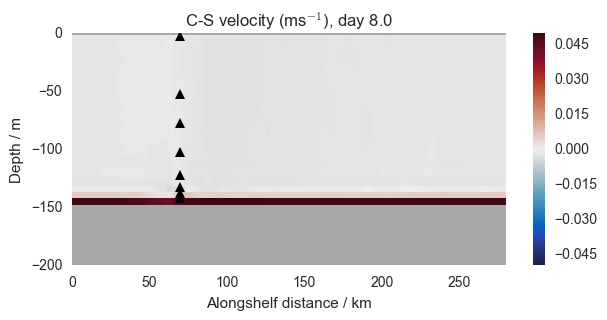

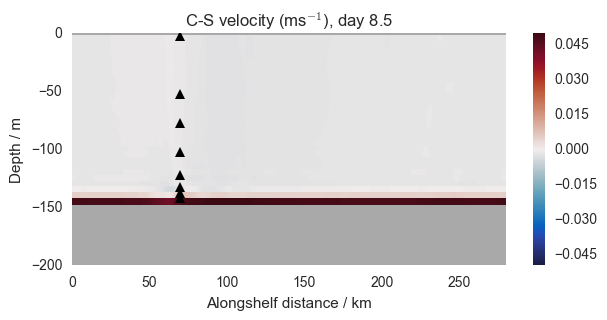

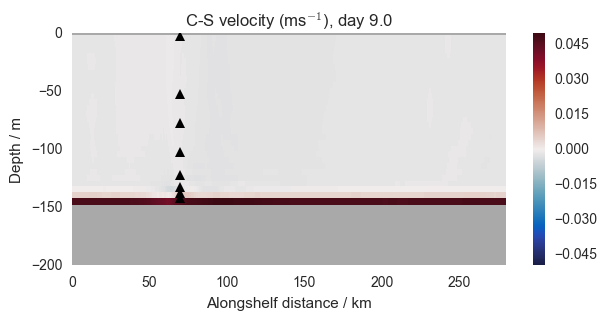

In [108]:
times = np.arange(19)
yind = 230
zslice = slice(0,40)
Transport = np.empty((len(times), len(Z[zslice])))
v_array = np.empty((len(times), 8))
depths = [0,10,15,20,24,26,27,28]

ii = 0

drF_exp = np.expand_dims(drF[zslice], axis=1) + np.zeros(np.shape(hFacSNoC[zslice,yind,:]))
dxF_exp = np.expand_dims(dxF[yind,:], axis=0) + np.zeros(np.shape(hFacSNoC[zslice,yind,:]))

for tt in times:
    
    fig, ax1 = plt.subplots(1,1,figsize=(7,3), sharey=True)
    ax1.set_axis_bgcolor("darkgrey")
    ax1.set_xlabel('Alongshelf distance / km')
    ax1.set_title('C-S velocity (ms$^{-1}$), day %1.1f' %(tt/2))
    
    with Dataset(state_fileNoC, 'r') as stf:
        Vstag = stf.variables['V'][tt,zslice,yind,:]
        #Vunstag = np.add(Vstag[..., :-1, :], Vstag[..., 1:, :]) / 2
        VV = np.ma.masked_array(Vstag, mask=maskSNoC[zslice,yind,:])
        v_array[tt,:] = VV[depths,240]
        
        for kk in range(len(Z[zslice])):
            Transport[ii,kk] = np.sum(VV[kk,:]*drF_exp[kk,:]*hFacSNoC[kk,yind,:]*dxF_exp[kk,:])
    ii=ii+1        
    pc1 = ax1.pcolor(X/1000,Z[zslice],VV, cmap=cmo.cm.balance, vmin=-0.05, vmax=0.05)
    plt.colorbar(pc1, ax=ax1)
    ax1.plot(X[240]*np.ones(np.shape(depths))/1000, Z[depths],'^k')
     
    ax1.set_ylabel('Depth / m')
    ax1.set_xlim(0,280)
    


Cross-shelf velocity at the depths marked with triangles in pcolors above:

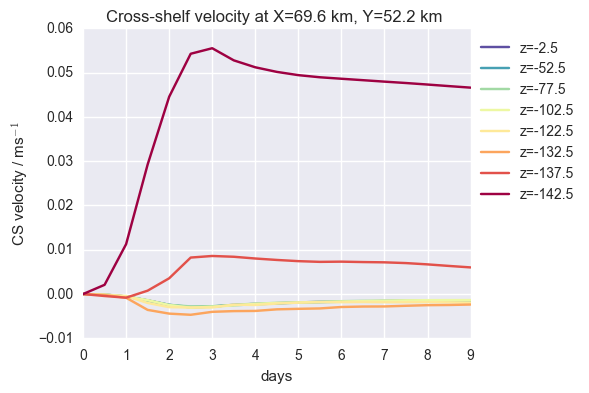

In [116]:
fig, ax1 = plt.subplots(1,1,figsize=(5,4), sharey=True)

cm_times = np.linspace(0,1,8)
colors = [cm.Spectral_r(x) for x in cm_times]

for kk,dep,cc in zip(range(len(depths)),depths,colors):
    
        ax1.plot(np.arange(19)/2,v_array[:,kk], color=cc, label=('z=%s' %Z[dep]))

ax1.legend(bbox_to_anchor=(1.3,1), ncol=1)
ax1.set_xlabel('days')
ax1.set_ylabel('CS velocity / ms$^{-1}$')
ax1.set_title('Cross-shelf velocity at X=69.6 km, Y=52.2 km ')

Concentration profiles at same cross section as C-S velocity pcolors above (They are in they are in different grids!):

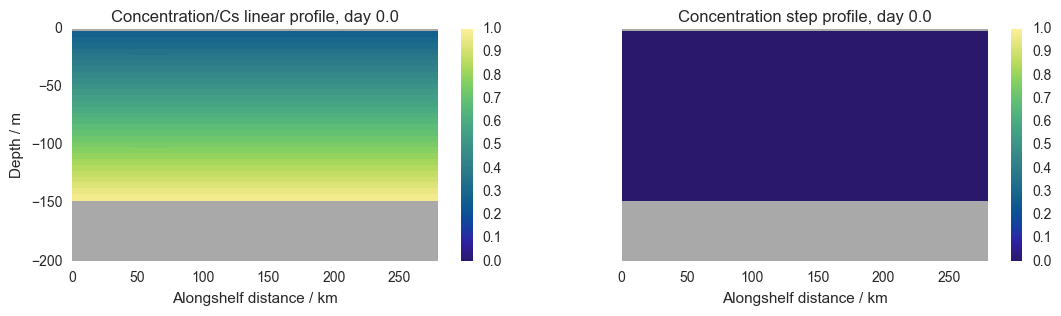

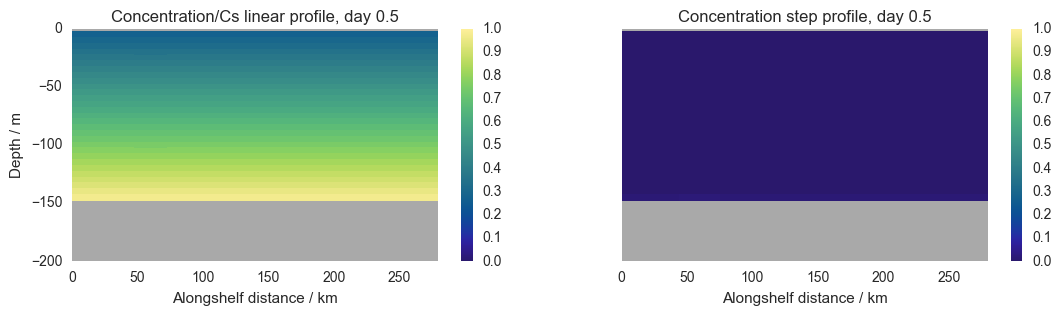

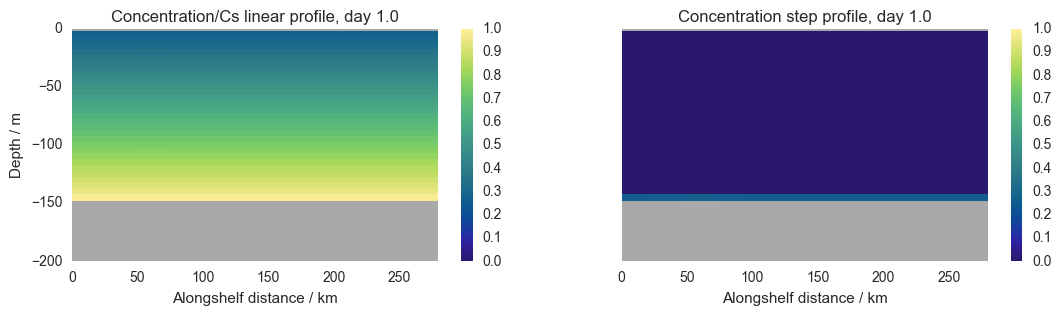

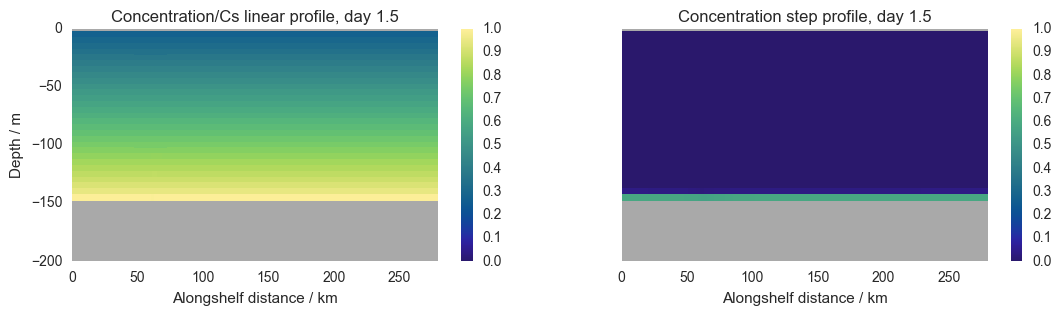

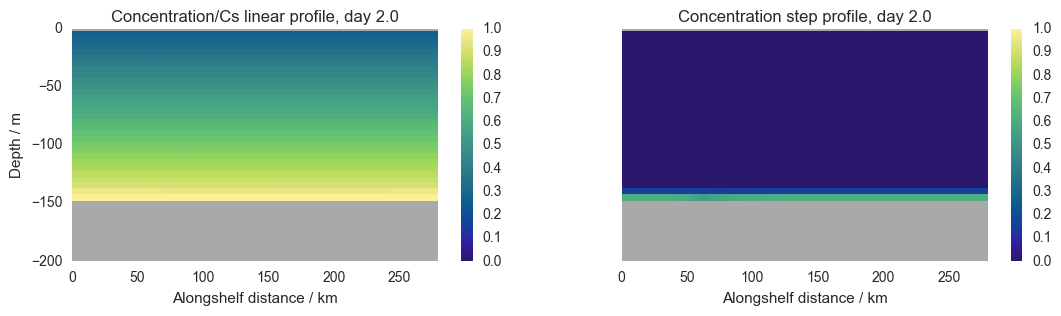

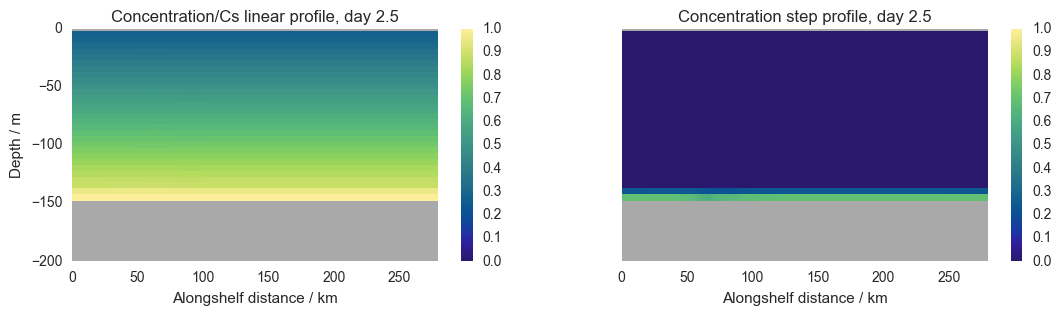

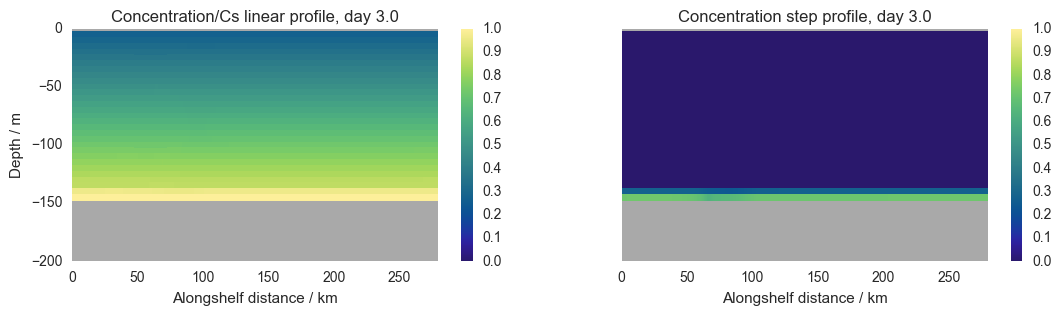

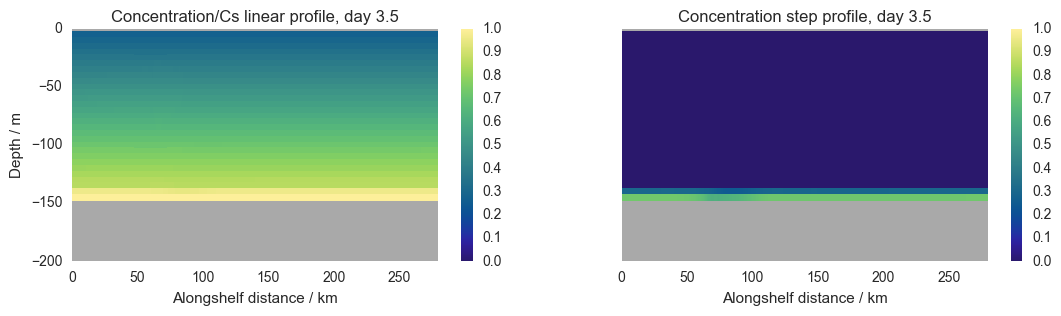

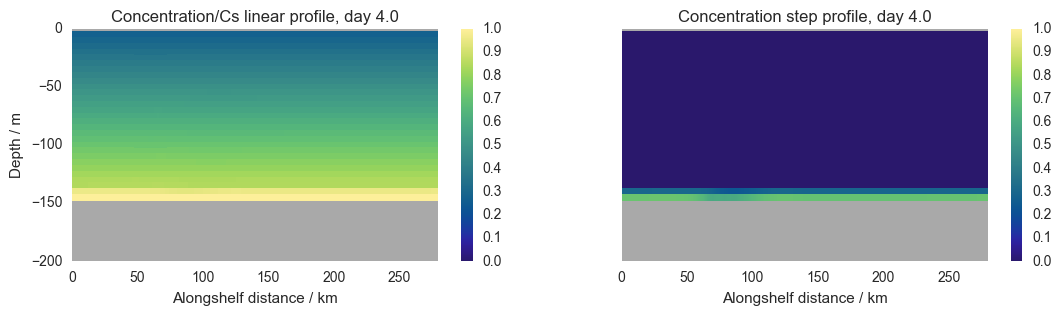

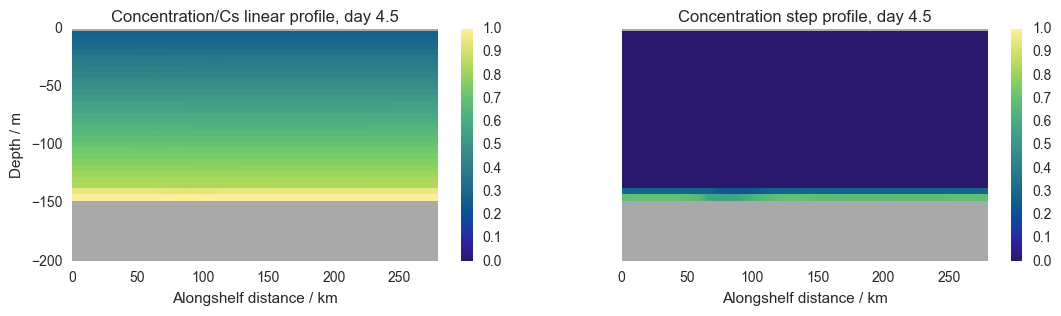

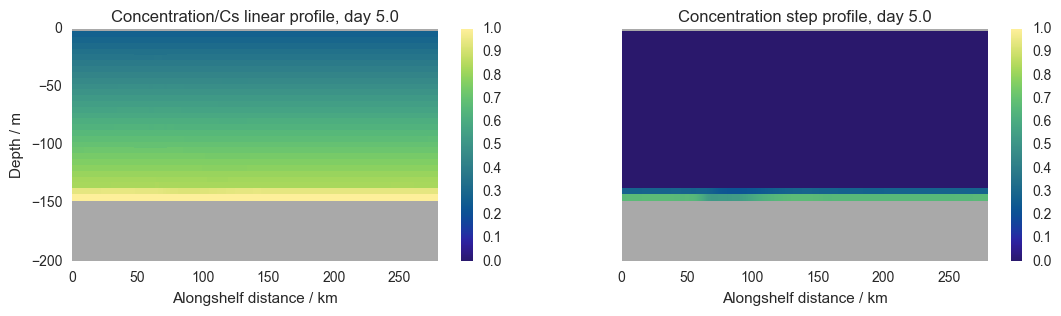

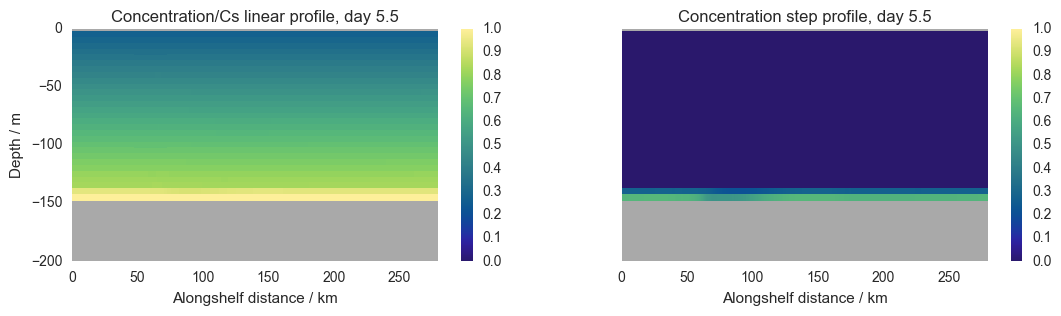

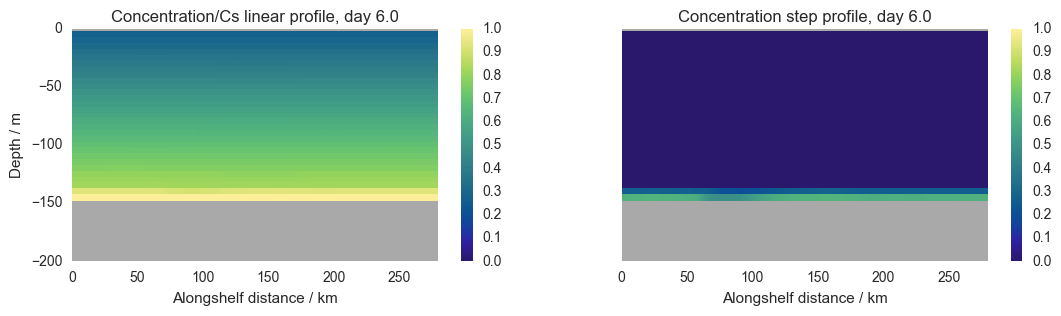

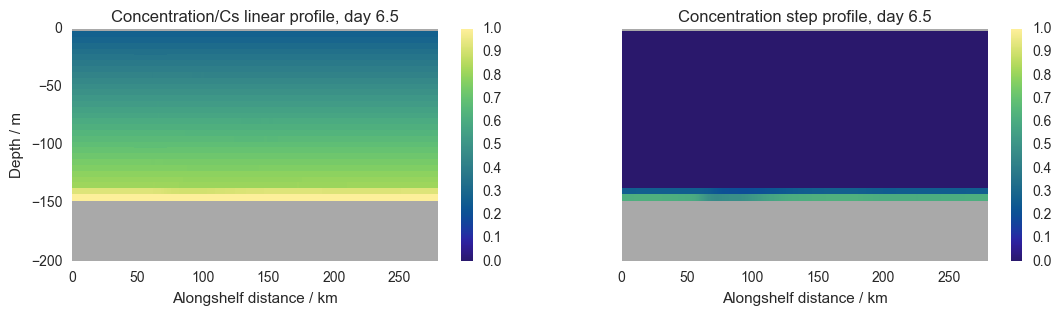

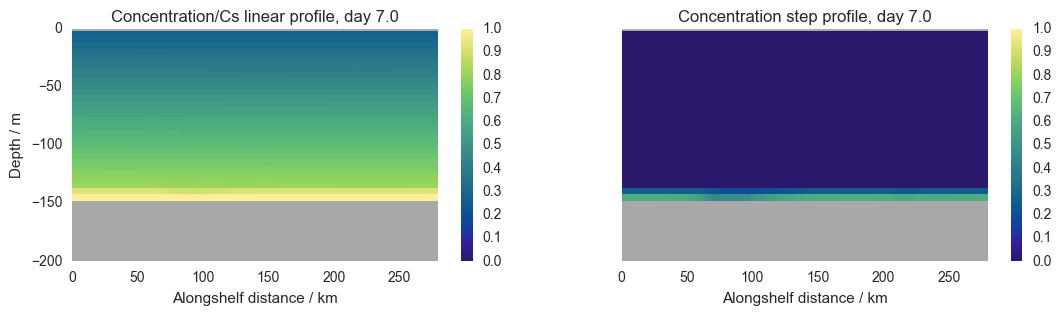

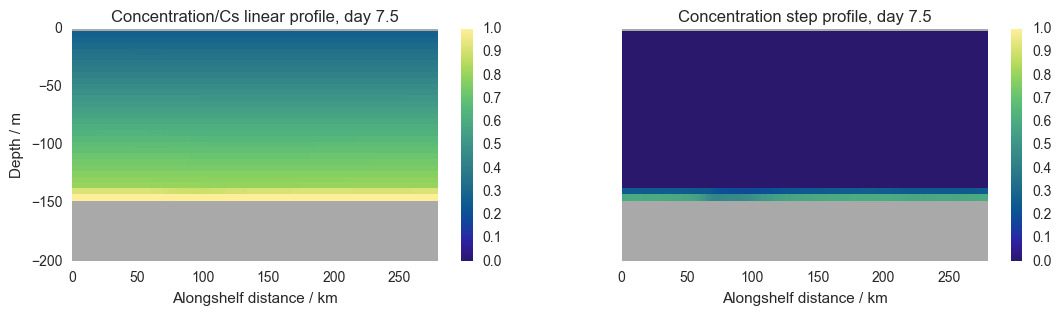

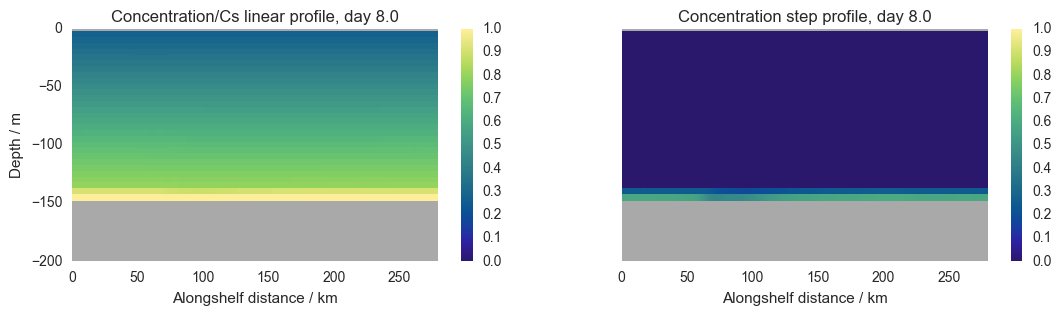

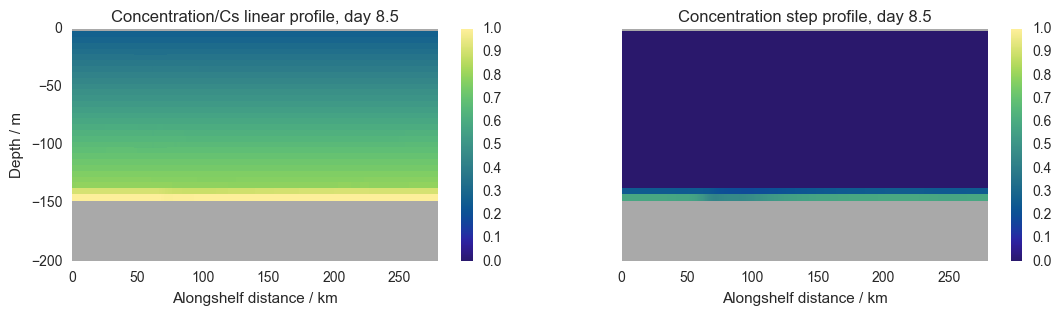

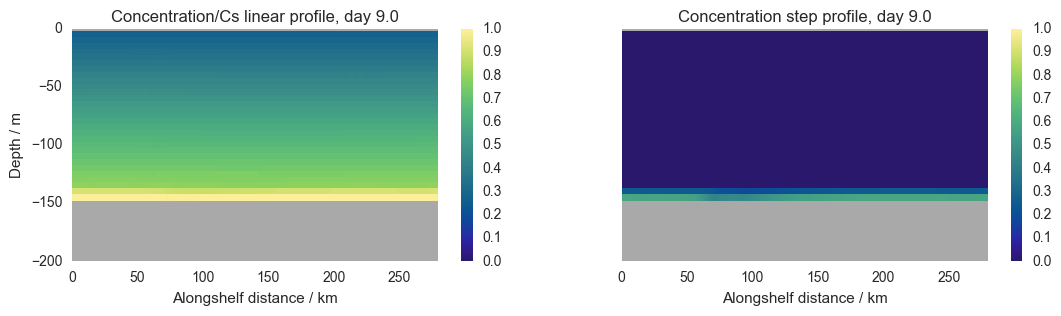

In [85]:
times = np.arange(19)
yind = 230
zslice = slice(0,40)

for tt in times:
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,3), sharey=True)
    ax1.set_axis_bgcolor("darkgrey")
    ax2.set_axis_bgcolor("darkgrey")
    ax1.set_xlabel('Alongshelf distance / km')
    ax2.set_xlabel('Alongshelf distance / km')
    ax1.set_title('Concentration/Cs linear profile, day %1.1f' %(tt/2))
    ax2.set_title('Concentration step profile, day %1.1f' %(tt/2))
    
    with Dataset(ptracers_fileNoC, 'r') as stf:
        Tr2 = stf.variables['Tr2'][tt,zslice,yind,:]
        Tr3 = stf.variables['Tr3'][tt,zslice,yind,:]
        Tr2masked = np.ma.masked_array(Tr2, mask=maskCNoC[zslice,yind,:])/7.21757317
        Tr3masked = np.ma.masked_array(Tr3, mask=maskCNoC[zslice,yind,:])
        
    ii=ii+1        
    pc1 = ax1.pcolor(X/1000,Z[zslice],Tr2masked, cmap=cmo.cm.haline, vmin=0, vmax=1)
    pc2 = ax2.pcolor(X/1000,Z[zslice],Tr3masked, cmap=cmo.cm.haline, vmin=0, vmax=1)
    plt.colorbar(pc1, ax=ax1)
    plt.colorbar(pc2, ax=ax2)
     
    ax1.set_ylabel('Depth / m')
    ax1.set_xlim(0,280)
    ax2.set_xlim(0,280)

Cross shelf transport at every depth (calculated in C-S pcolors above). The total (solid back line) is zero, but there is on-shelf transport near the shelf bottom throughout the whole simulation (Also seen in C-S velocity plots):

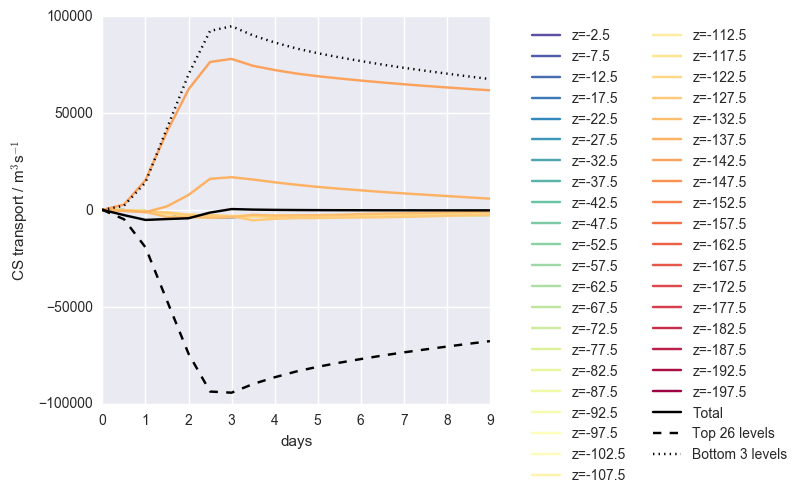

In [95]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5), sharey=True)

cm_times = np.linspace(0,1,40)
colors = [cm.Spectral_r(x) for x in cm_times]

for kk,cc in zip(range(len(Z[zslice])),colors):
    
        ax1.plot(np.arange(19)/2,Transport[:,kk], color=cc, label=('z=%s' %Z[kk]))

ax1.plot(np.arange(19)/2,np.nansum(Transport, axis=1), 'k', label='Total')

ax1.plot(np.arange(19)/2,np.nansum(Transport[:,:27], axis=1), 'k--', label='Top 26 levels')

ax1.plot(np.arange(19)/2,np.nansum(Transport[:,27:], axis=1), 'k:', label='Bottom 3 levels')

ax1.legend(bbox_to_anchor=(1.8,1), ncol=2)
ax1.set_xlabel('days')
ax1.set_ylabel('CS transport / m$^3$s$^{-1}$')

Integrated transport near the bottom (on-shelf portion). According to this plot, by the end of 9 days $5\times10^{11}$ m$^3$ of water have been transported onto the shelf.

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


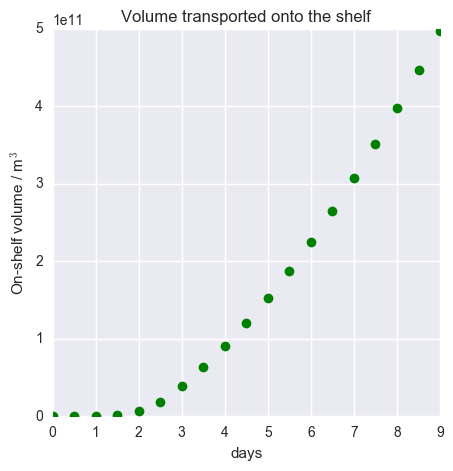

In [117]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5), sharey=True)

for tt in range(19):
    ax1.plot(tt/2,np.nansum((np.nansum(Transport[:tt,27:], axis=1)*(np.arange(tt)*3600*12)),axis=0), 'go')
   

ax1.legend(bbox_to_anchor=(1.8,1), ncol=2)
ax1.set_xlabel('days')
ax1.set_ylabel('On-shelf volume / m$^3$')
ax1.set_title('Volume transported onto the shelf')